In [1]:
# Import libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [2]:
raw_flight_history = pd.read_csv('data/API_IS.AIR.DPRT_DS2_en_csv_v2_6211.csv')
raw_flight_history.drop(['2018', 'Unnamed: 63'], axis = 1, inplace = True)

In [3]:
total_flights = raw_flight_history[raw_flight_history['Country Name'] == 'World']
total_flights = pd.DataFrame(total_flights.select_dtypes(pd.np.number).sum().rename('total'))
total_flights = total_flights.reset_index().rename(columns = {'index': 'year_date'})
total_flights['year_date'] = total_flights['year_date'].astype('int')

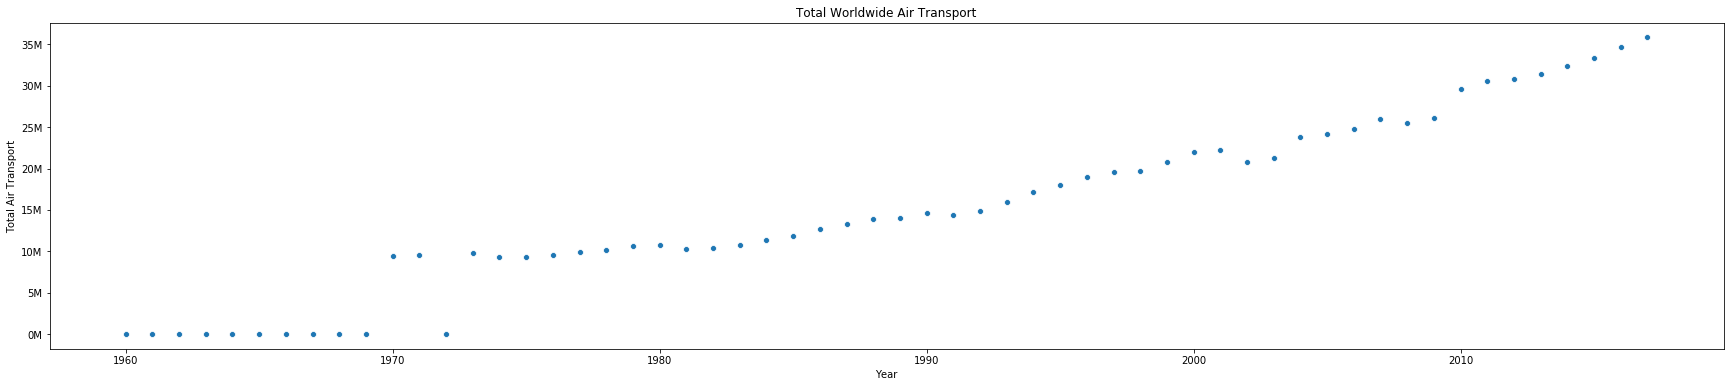

In [4]:
plt.figure(figsize=(30, 6))
g = sns.scatterplot(x="year_date", y="total", data=total_flights)
ylabels = ['{:,.0f}'.format(x) + 'M' for x in g.get_yticks()/1000000]
g.set_yticklabels(ylabels);
g.set_title('Total Worldwide Air Transport');
g.set(xlabel='Year', ylabel='Total Air Transport');

In [65]:
temp = total_flights[total_flights['year_date'] >= 1995].reset_index(drop=True)
x = temp['year_date'].values.reshape(-1, 1)
y = temp['total'].values
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict([[2018], [2019], [2020], [2021]])

In [66]:
step = 0
for i in range(2018, 2022):
    total_flights.loc[len(total_flights)+1] = [i, y_pred[step]]
    step += 1

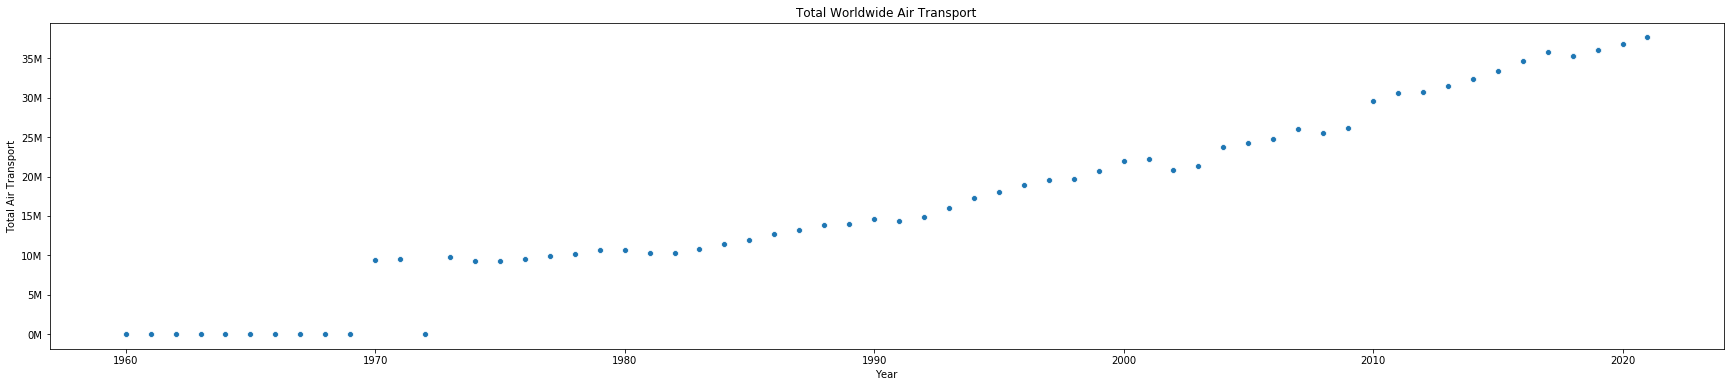

In [67]:
plt.figure(figsize=(30, 6))
g = sns.scatterplot(x="year_date", y="total", data=total_flights)
ylabels = ['{:,.0f}'.format(x) + 'M' for x in g.get_yticks()/1000000]
g.set_yticklabels(ylabels);
g.set_title('Total Worldwide Air Transport');
g.set(xlabel='Year', ylabel='Total Air Transport');

In [68]:
raw_data = pd.read_csv('data/raw.csv', sep = '|')

In [69]:
# clean column time
data_c = raw_data.copy()
data_c['time'] = data_c.time.str.replace('c', '')\
    .str.replace(':','')\
    .str.replace(';','')\
    .str.replace('Z','')\
    .str.replace('"','')\
    .str.replace('.','')\
    .str.replace('?', '0000')
data_c['time'] = data_c.time.str.strip()
data_c['time'] = np.where(data_c['time'].str.len() < 4, '0'+data_c['time'], data_c['time'])
data_c['time'] = np.where(data_c['time'].str.len() > 4, data_c['time'].str[:-1], data_c['time'])

# replace ? with NANs
data_nan = data_c.copy()
cols = ['cn_ln',
        'crew_aboard',
        'crew_fatalities',
        'date',
        'flight_no',
        'ground',
        'location',
        'operator',
        'passengers_aboard',
        'passengers_fatalities',
        'registration',
        'route',
        'summary',
        'total_aboard']

for col in cols:
    data_nan[col] = np.where(data_nan[col] == '?', np.nan, data_nan[col])

# remove leading and trailing white spaces
for col in ['ac_type', 'location', 'operator', 'route', 'summary']:
    data_nan[col] = data_nan[col].str.strip()

# format date-time
data_dt = data_nan.copy()
data_dt['dt'] = data_dt['date'] + ' ' + data_dt['time']
data_dt['dt'] = pd.to_datetime(data_dt['dt'], format='%B %d, %Y %H%M')
data_dt['year_date'] = data_dt['dt'].dt.to_period("Y")
data_dt['year_date'] = data_dt['year_date'].astype('str')

In [70]:
data_dt = data_dt[(data_dt['year_date'] != '2018') & (data_dt['year_date'] != '2019')]

In [189]:
data_grouped = pd.DataFrame(data_dt['dt'].groupby(data_dt['dt'].dt.to_period("Y")).agg('count'))
data_grouped.rename(columns = {'dt': 'count'}, inplace = True)
data_grouped = data_grouped.reset_index().rename(columns = {'dt': 'year_date'})
data_grouped['year_date'] = data_grouped['year_date'].astype('str')
data_grouped['year_date'] = data_grouped['year_date'].astype('int')

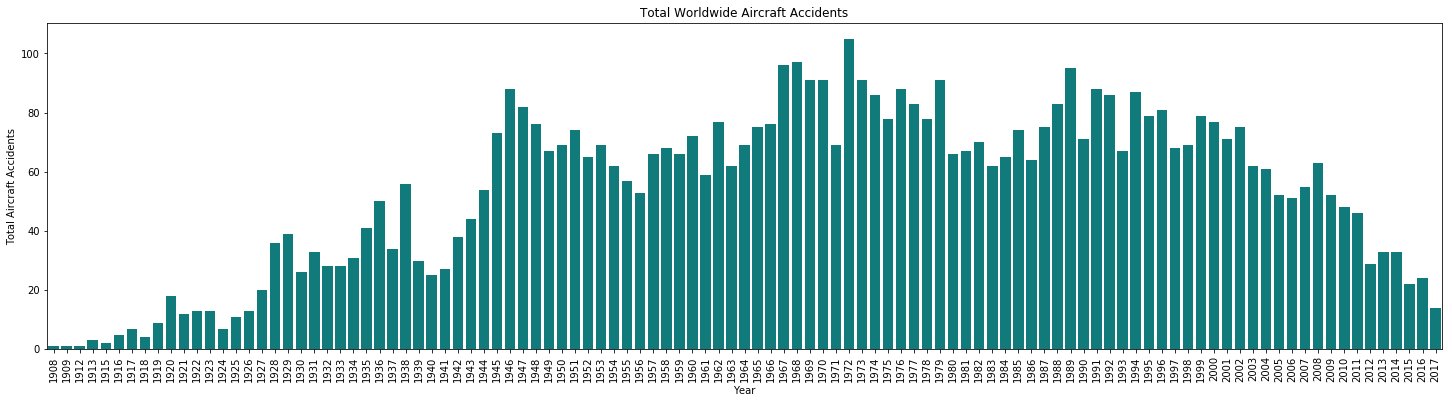

In [190]:
plt.figure(figsize=(25, 6))
g = sns.barplot(x="year_date", y="count", data=data_grouped, color="darkcyan");
g.set_xticklabels(g.get_xticklabels(),rotation=90);
g.set_title('Total Worldwide Aircraft Accidents');
g.set(xlabel='Year', ylabel='Total Aircraft Accidents');

In [191]:
model = LinearRegression()
temp = data_grouped[(data_grouped['year_date'] >= 1989)].reset_index(drop=True)
x = temp['year_date'].values.reshape(-1, 1)
y = temp['count'].values
model.fit(x, np.log(y))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [193]:
y_pred = model.predict([[2018], [2019], [2020], [2021]])
step = 0
for i in range(2018, 2022):
    data_grouped.loc[len(data_grouped)+1] = [int(i), np.exp(y_pred[step])]
    step += 1

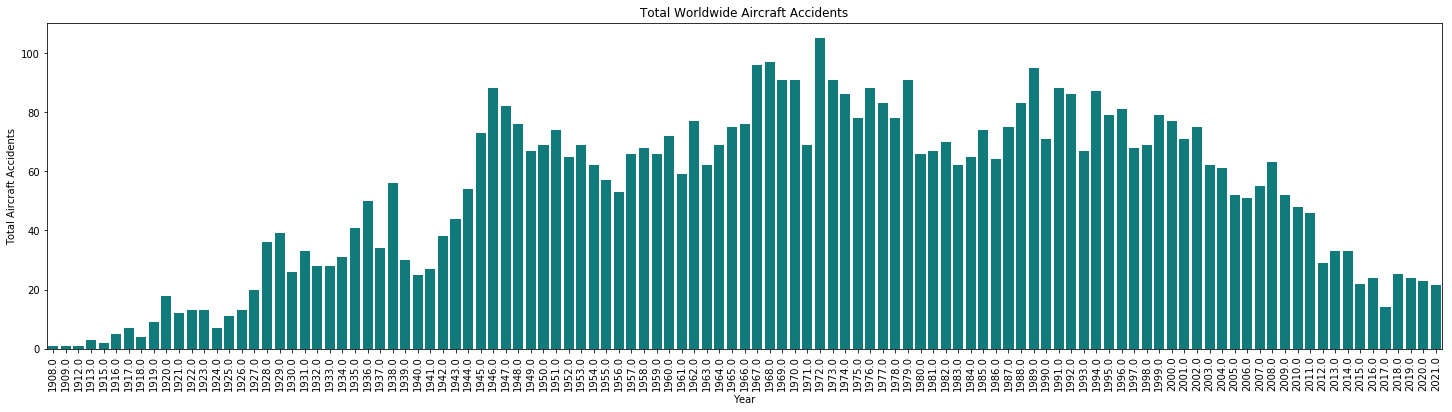

In [195]:
plt.figure(figsize=(25, 6))
g = sns.barplot(x="year_date", y="count", data=data_grouped, color="darkcyan");
g.set_xticklabels(g.get_xticklabels(),rotation=90);
g.set_title('Total Worldwide Aircraft Accidents');
g.set(xlabel='Year', ylabel='Total Aircraft Accidents');

In [50]:
# data_grouped.loc[len(data_grouped)+1] = [2018,model_fit[0]*np.log(2018) + model_fit[1]]
# data_grouped.loc[len(data_grouped)+1] = [2019,model_fit[0]*np.log(2019) + model_fit[1]]

In [196]:
flight_data = pd.merge(data_grouped, total_flights, on='year_date', how='inner')
flight_data = flight_data[flight_data['year_date'] >= 1973].reset_index(drop=True)

In [197]:
flight_data['failure_perc'] = flight_data['count']/flight_data['total']

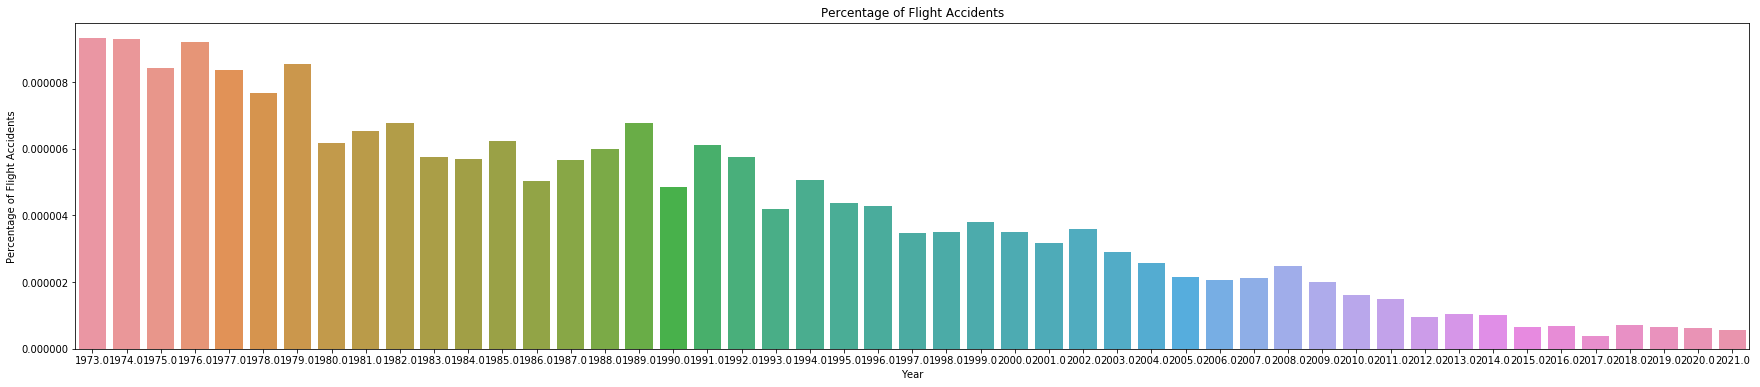

In [198]:
plt.figure(figsize=(30, 6))
g = sns.barplot(x="year_date", y="failure_perc", data=flight_data)
g.set_title('Percentage of Flight Accidents');
g.set(xlabel='Year', ylabel='Percentage of Flight Accidents');